# Lecture 4 - PubChem + CIR

```{contents}
:local:
:depth: 1
```

## Learning goals

- Understand PubChem as a data service via **PUG-REST** and **PUG-View**.  
- Form URLs that return JSON, TXT or images.  
- Resolve names, SMILES and CAS numbers to CIDs.  
- Retrieve IUPAC, SMILES, InChIKey and selected properties.  
- Use the **NCI Chemical Identifier Resolver (CIR)** as a second query path.  
- Build small helper functions with error handling and fallbacks.  
- Practice with a real Excel sheet of ligands that contains CAS numbers.  
- Create a tiny widget that accepts name or SMILES or CAS and returns a summary and a GIF.  

---

## 1. PubChem PUG-REST Basics



### 1.1 Setup

In [1]:
# Networking
try:
    import requests
except Exception:
    %pip -q install requests
    import requests

from urllib.parse import quote_plus

# Optional drawing and widgets
try:
    from rdkit import Chem
    from rdkit.Chem import Draw, Descriptors, Crippen, rdMolDescriptors, AllChem
except Exception:
    try:
        %pip -q install rdkit-pypi
        from rdkit import Chem
        from rdkit.Chem import Draw, Descriptors, Crippen, rdMolDescriptors, AllChem
    except Exception as e:
        print("RDKit is not available in this environment. Drawing and descriptors will be skipped.")
        Chem = None

try:
    import ipywidgets as widgets
    from IPython.display import display, HTML, Image, clear_output
except Exception:
    try:
        %pip -q install ipywidgets
        import ipywidgets as widgets
        from IPython.display import display, HTML, Image, clear_output
    except Exception:
        widgets = None

try:
    from PIL import Image as PILImage
    from io import BytesIO
except Exception:
    %pip -q install pillow
    from PIL import Image as PILImage
    from io import BytesIO

Note: you may need to restart the kernel to use updated packages.


---

### 1.2 Background Information


Instead of going to [PubChem’s main site](https://pubchem.ncbi.nlm.nih.gov) and manually searching for a compound, we can also use a **direct URL** to query PubChem’s REST API. This allows us to send structured requests and retrieve data in machine-readable formats such as JSON, XML, or plain text. 

The figure below illustrates the general workflow of PUG-REST: provide an input (like a compound name), choose an operation (for example, retrieving a CID), and specify the output format. Using URLs in this way not only automates lookups but also integrates PubChem data smoothly into code and analysis.






![PubChem PUG-REST Figure](https://iupac.github.io/WFChemCookbook/_images/pubchem_pugrest_fig1.jpg)

Here is a summary:

- **Input**: name, CID, InChIKey, SMILES, or CAS number.  
- **Operation**: what property you want (CID, IUPAC, SMILES, etc.).  
- **Output**: JSON, XML, or TXT.  

Here are some example URLs you can click and explore directly in a browser:
- [https://pubchem.ncbi.nlm.nih.gov/rest/pug/compound/name/aspirin/cids/JSON](https://pubchem.ncbi.nlm.nih.gov/rest/pug/compound/name/aspirin/cids/JSON): Returns the PubChem Compound ID (CID) for aspirin.
- [https://pubchem.ncbi.nlm.nih.gov/rest/pug/compound/cid/2244/property/IUPACName/JSON](https://pubchem.ncbi.nlm.nih.gov/rest/pug/compound/cid/2244/property/IUPACName/JSON): Returns the standardized IUPAC name.
- [https://pubchem.ncbi.nlm.nih.gov/rest/pug/compound/cid/2244/property/CanonicalSMILES/JSON](https://pubchem.ncbi.nlm.nih.gov/rest/pug/compound/cid/2244/property/CanonicalSMILES/JSON): Returns the canonical SMILES string representation.




```{note}
The key idea is that PubChem is not only a website but also a programmatic data service. A well-formed URL acts like a query to their database.
```


If you are interested in learning more about PubChem URL, please read:
- [IUPAC FAIR Chemistry Cookbook guide](https://iupac.github.io/WFChemCookbook/datasources/pubchem_pugrest1.html)

```{note}
Always read the URL as:  
1. Base: `https://pubchem.ncbi.nlm.nih.gov/rest/pug`  
2. Section: `compound` (since we work with compounds)  
3. Identifier type: `name`, `cid`, `smiles`, `cas`  
4. Action: what property to fetch  
5. Format: `JSON`, `XML`, `TXT`  
```



---

## 2. From name to CID and properties

### 2.1 Form the URL

In [2]:
name = "acetaminophen"
url = f"https://pubchem.ncbi.nlm.nih.gov/rest/pug/compound/name/{quote_plus(name)}/cids/JSON"
print(url)

https://pubchem.ncbi.nlm.nih.gov/rest/pug/compound/name/acetaminophen/cids/JSON


```{note}
Try pasting this URL into your browser. You should see a JSON object with `"CID"`.  
```

### 2.2 Request and parse

In [3]:
# Install requests if you do not have it
try:
    import requests
except Exception:
    %pip -q install requests
    import requests

from urllib.parse import quote_plus  

In [4]:
r = requests.get(url, timeout=30)
data = r.json()
print(data)

{'IdentifierList': {'CID': [1983]}}


Break it down:

In [5]:
print(data.keys())
print(data.get("IdentifierList", {}))

dict_keys(['IdentifierList'])
{'CID': [1983]}


In [6]:
cid_list = data.get("IdentifierList", {}).get("CID", [])
cid = cid_list[0]
print("CID:", cid)

CID: 1983


---


### 2.3 IUPAC name

In [7]:
cid = 2244  # aspirin
url = f"https://pubchem.ncbi.nlm.nih.gov/rest/pug/compound/cid/{cid}/property/IUPACName/JSON"
r = requests.get(url, timeout=30)
r.raise_for_status()
props = r.json()["PropertyTable"]["Properties"][0]
print("IUPAC:", props["IUPACName"])

IUPAC: 2-acetyloxybenzoic acid


### 2.4 Canonical vs isomeric SMILES

In [8]:
canon = requests.get(f"https://pubchem.ncbi.nlm.nih.gov/rest/pug/compound/cid/{cid}/property/CanonicalSMILES/TXT", timeout=30).text.strip()
iso   = requests.get(f"https://pubchem.ncbi.nlm.nih.gov/rest/pug/compound/cid/{cid}/property/IsomericSMILES/TXT", timeout=30).text.strip()
print("Canonical:", canon)
print("Isomeric :", iso)

Canonical: CC(=O)OC1=CC=CC=C1C(=O)O
Isomeric : CC(=O)OC1=CC=CC=C1C(=O)O


```{note}
Canonical SMILES is normalized and does not carry stereochemistry.  
Isomeric SMILES includes stereochemistry and isotopes if available.
```

---

### 2.5 Safer helpers

In [9]:
def safe_get_json(url, timeout=30):
    r = requests.get(url, timeout=timeout)
    r.raise_for_status()
    return r.json()

def safe_get_text(url, timeout=30):
    r = requests.get(url, timeout=timeout)
    r.raise_for_status()
    return r.text.strip()

def safe_get_bytes(url, timeout=30):
    r = requests.get(url, timeout=timeout)
    r.raise_for_status()
    return r.content

---


### 2.6 Write convenience functions (by name)

In [10]:
def pubchem_by_name(name, isomeric=True):
    enc = quote_plus(name.strip())
    kind = "IsomericSMILES" if isomeric else "CanonicalSMILES"
    smi_url = f"https://pubchem.ncbi.nlm.nih.gov/rest/pug/compound/name/{enc}/property/{kind}/TXT"
    smiles = safe_get_text(smi_url)

    cid_url = f"https://pubchem.ncbi.nlm.nih.gov/rest/pug/compound/name/{enc}/cids/JSON"
    cid_list = safe_get_json(cid_url).get("IdentifierList", {}).get("CID", [])
    if not cid_list:
        raise ValueError("No CID found")
    cid = cid_list[0]

    iupac_url = f"https://pubchem.ncbi.nlm.nih.gov/rest/pug/compound/cid/{cid}/property/IUPACName/TXT"
    iupac = safe_get_text(iupac_url)

    inchikey_url = f"https://pubchem.ncbi.nlm.nih.gov/rest/pug/compound/cid/{cid}/property/InChIKey/TXT"
    inchikey = safe_get_text(inchikey_url)

    return {"input": name, "cid": cid, "smiles": smiles, "iupac": iupac, "inchikey": inchikey}

pubchem_by_name("ibuprofen")

{'input': 'ibuprofen',
 'cid': 3672,
 'smiles': 'CC(C)CC1=CC=C(C=C1)C(C)C(=O)O',
 'iupac': '2-[4-(2-methylpropyl)phenyl]propanoic acid',
 'inchikey': 'HEFNNWSXXWATRW-UHFFFAOYSA-N'}

### 2.7 Write convenience functions (by CID)

In [11]:
def pubchem_by_cid(cid, isomeric=True):
    cid = int(cid)
    kind = "IsomericSMILES" if isomeric else "CanonicalSMILES"
    smi_url = f"https://pubchem.ncbi.nlm.nih.gov/rest/pug/compound/cid/{cid}/property/{kind}/TXT"
    smiles = safe_get_text(smi_url)
    iupac_url = f"https://pubchem.ncbi.nlm.nih.gov/rest/pug/compound/cid/{cid}/property/IUPACName/TXT"
    iupac = safe_get_text(iupac_url)
    inchikey_url = f"https://pubchem.ncbi.nlm.nih.gov/rest/pug/compound/cid/{cid}/property/InChIKey/TXT"
    inchikey = safe_get_text(inchikey_url)
    return {"cid": cid, "smiles": smiles, "iupac": iupac, "inchikey": inchikey}

pubchem_by_cid(2244)

{'cid': 2244,
 'smiles': 'CC(=O)OC1=CC=CC=C1C(=O)O',
 'iupac': '2-acetyloxybenzoic acid',
 'inchikey': 'BSYNRYMUTXBXSQ-UHFFFAOYSA-N'}

---

## 3. Other PubChem features

### 3.1 Selected computed properties

In [12]:
def pubchem_properties(cid, fields=("MolecularWeight","XLogP","ExactMass","HBondDonorCount","HBondAcceptorCount","TPSA")):
    cid = int(cid)
    field_str = ",".join(fields)
    url = f"https://pubchem.ncbi.nlm.nih.gov/rest/pug/compound/cid/{cid}/property/{field_str}/JSON"
    data = safe_get_json(url)
    return data["PropertyTable"]["Properties"][0]

pubchem_properties(2244)

{'CID': 2244,
 'MolecularWeight': '180.16',
 'XLogP': 1.2,
 'ExactMass': '180.04225873',
 'TPSA': 63.6,
 'HBondDonorCount': 1,
 'HBondAcceptorCount': 4}

### 3.2 Synonyms

In [13]:
def pubchem_synonyms(cid, limit=10):
    url = f"https://pubchem.ncbi.nlm.nih.gov/rest/pug/compound/cid/{int(cid)}/synonyms/JSON"
    syns = safe_get_json(url).get("InformationList", {}).get("Information", [{}])[0].get("Synonym", [])
    return syns[:limit]

pubchem_synonyms(2244, limit=8)

['aspirin',
 'ACETYLSALICYLIC ACID',
 '50-78-2',
 '2-Acetoxybenzoic acid',
 '2-(Acetyloxy)benzoic acid',
 'O-Acetylsalicylic acid',
 'o-Acetoxybenzoic acid',
 'Acylpyrin']

### 3.3 PNG depiction from PubChem

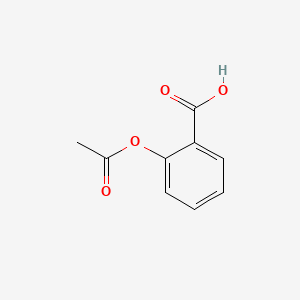

In [14]:
def pubchem_png_by_cid(cid, size=300):
    url = f"https://pubchem.ncbi.nlm.nih.gov/rest/pug/compound/cid/{int(cid)}/PNG?image_size={int(size)}x{int(size)}"
    return safe_get_bytes(url)

png_bytes = pubchem_png_by_cid(2244, size=300)
display(Image(data=png_bytes))

### 3.4 PUG-View for safety snippets

`PUG-View` serves formatted record content such as GHS classification. The path is:

```
https://pubchem.ncbi.nlm.nih.gov/rest/pug_view/data/compound/<cid>/JSON
```

The JSON is nested. The simple utility below searches for any block whose title contains a keyword.

In [15]:
def pug_view_find_sections(cid, keyword="GHS"):
    url = f"https://pubchem.ncbi.nlm.nih.gov/rest/pug_view/data/compound/{int(cid)}/JSON"
    data = safe_get_json(url)
    hits = []
    def walk(sections, path=""):
        for sec in sections or []:
            title = sec.get("TOCHeading", "") or sec.get("Title", "")
            if keyword.lower() in title.lower():
                hits.append({"title": title, "path": path + " > " + title, "section": sec})
            walk(sec.get("Section"), path + " > " + title)
    rec = data.get("Record", {})
    walk(rec.get("Section"))
    return hits

ghs_hits = pug_view_find_sections(2244, "GHS")
[x["title"] for x in ghs_hits][:5]

['GHS Classification', 'UN GHS Classification']

To show a short plain text summary, extract strings in the first hit:

In [16]:
def pug_view_text_from_hit(hit, max_lines=12):
    lines = []
    def walk(sec):
        for i in sec.get("Information", []) or []:
            sval = i.get("Value", {}).get("StringWithMarkup", [])
            for s in sval:
                txt = s.get("String", "").strip()
                if txt:
                    lines.append(txt)
        for ch in sec.get("Section", []) or []:
            walk(ch)
    walk(hit["section"])
    return "\n".join(lines[:max_lines])

if ghs_hits:
    print(pug_view_text_from_hit(ghs_hits[0]))

This chemical does not meet GHS hazard criteria for 0.3% (1  of 315) of reports.
Warning
H302 (95.6%): Harmful if swallowed [Warning Acute toxicity, oral]
H315 (20.6%): Causes skin irritation [Warning Skin corrosion/irritation]
H319 (22.2%): Causes serious eye irritation [Warning Serious eye damage/eye irritation]
H335 (20%): May cause respiratory irritation [Warning Specific target organ toxicity, single exposure; Respiratory tract irritation]
P261, P264, P264+P265, P270, P271, P280, P301+P317, P302+P352, P304+P340, P305+P351+P338, P319, P321, P330, P332+P317, P337+P317, P362+P364, P403+P233, P405, and P501
Aggregated GHS information provided per 315 reports by companies from 23 notifications to the ECHA C&L Inventory. Each notification may be associated with multiple companies.
Reported as not meeting GHS hazard criteria per 1 of 315 reports by companies.
There are 22 notifications provided by 314 of 315 reports by companies with hazard statement code(s).
Information may vary between

---

## 4. NCI Chemical Identifier Resolver (CIR) as a second path

Base URL:

```
https://cactus.nci.nih.gov/chemical/structure/<input>/<output>
```

Useful outputs: `smiles`, `stdinchi`, `stdinchikey`, `names`, `cas`, `image`, `mw`

In [17]:
def cir_get(q, out="smiles"):
    q_enc = quote_plus(str(q).strip())
    url = f"https://cactus.nci.nih.gov/chemical/structure/{q_enc}/{out}"
    try:
        if out == "image":
            return safe_get_bytes(url)
        else:
            return safe_get_text(url)
    except Exception as e:
        return None

print("SMILES:", cir_get("aspirin", "smiles"), "...")
print("InChIKey:", cir_get("aspirin", "stdinchikey"))
print("CAS:", cir_get("aspirin", "cas"))

SMILES: CC(=O)Oc1ccccc1C(O)=O ...
InChIKey: InChIKey=BSYNRYMUTXBXSQ-UHFFFAOYSA-N


CAS: 50-78-2
11126-35-5
11126-37-7
2349-94-2
26914-13-6
98201-60-6


### 4.1 Simple fallback for SMILES

In [18]:
def get_smiles_with_fallback(query):
    # Try PubChem first
    try:
        if str(query).isdigit():
            smi = safe_get_text(f"https://pubchem.ncbi.nlm.nih.gov/rest/pug/compound/cid/{int(query)}/property/IsomericSMILES/TXT")
        else:
            smi = safe_get_text(f"https://pubchem.ncbi.nlm.nih.gov/rest/pug/compound/name/{quote_plus(str(query))}/property/IsomericSMILES/TXT")
        if smi:
            return smi
    except Exception:
        pass
    # Fallback to CIR
    return cir_get(query, "smiles")

print(get_smiles_with_fallback("ibuprofen"))

CC(C)CC1=CC=C(C=C1)C(C)C(=O)O


---

## 5. Mini widget

Enter a **name or CID or SMILES or CAS** and show a quick summary. Generates a small GIF from a PNG depiction so it can be shared easily.

In [19]:
def to_small_gif_from_png_bytes(png_bytes, out_size=(240,240)):
    try:
        im = PILImage.open(BytesIO(png_bytes)).convert("RGBA")
        im = im.resize(out_size)
        # two-frame GIF blink to satisfy the GIF requirement
        bio = BytesIO()
        im.save(bio, format="GIF", save_all=True, append_images=[im], duration=600, loop=0)
        return bio.getvalue()
    except Exception as e:
        return None

def quick_summary(query, source="PubChem"):
    q = str(query).strip()
    summary = {"query": q, "source": source}
    try:
        if source == "PubChem":
            if q.isdigit():
                info = pubchem_by_cid(int(q))
            else:
                info = pubchem_by_name(q)
            summary.update(info)
            png = pubchem_png_by_cid(summary["cid"], size=300)
            gif_bytes = to_small_gif_from_png_bytes(png)
            summary["gif"] = gif_bytes
        else:
            smi = get_smiles_with_fallback(q)
            summary["smiles"] = smi
            summary["inchikey"] = cir_get(q, "stdinchikey")
            summary["iupac"] = cir_get(q, "iupac_name")
            img = cir_get(q, "image")
            summary["gif"] = to_small_gif_from_png_bytes(img) if img else None
        return summary
    except Exception as e:
        summary["error"] = str(e)
        return summary

if widgets is not None:
    inp = widgets.Text(value="aspirin", description="Query:", layout=widgets.Layout(width="60%"))
    src = widgets.ToggleButtons(options=["PubChem","CIR"], description="Source:")
    btn = widgets.Button(description="Fetch", button_style="primary")
    out = widgets.Output()

    def run_fetch(b):
        with out:
            clear_output()
            res = quick_summary(inp.value, source=src.value)
            if "error" in res:
                print("Error:", res["error"])
                return
            print("Source:", res.get("source"))
            print("CID:", res.get("cid"))
            print("IUPAC:", res.get("iupac"))
            print("SMILES:", res.get("smiles"))
            print("InChIKey:", res.get("inchikey"))
            if res.get("gif"):
                display(Image(data=res["gif"]))
            else:
                print("No image available")
    btn.on_click(run_fetch)
    display(widgets.HBox([inp, src, btn]), out)
else:
    print("ipywidgets is not available in this environment.")

Output()

---

## 6. Case study with CAS from Excel

We will re-use the inventory file:

📂 `organic ligands inventory.xlsx`  
<https://raw.githubusercontent.com/zzhenglab/ai4chem/main/book/_data/organic_ligands_inventory.xlsx>

In [20]:
import pandas as pd

url = "https://raw.githubusercontent.com/zzhenglab/ai4chem/main/book/_data/organic_ligands_inventory.xlsx"
df = pd.read_excel(url, engine="openpyxl")
df.head()

ImportError: Missing optional dependency 'openpyxl'.  Use pip or conda to install openpyxl.

```{admonition} Why "openpyxl"?
In previous example, we directly read csv. However, to access excell spreedsheet, we need to specify `engine="openpyxl"`.

```

### 6.1 Query PubChem by CAS with fallback

In [ ]:
def by_cas_with_fallback(cas, isomeric=True):
    enc = quote_plus(str(cas))
    try:
        kind = "IsomericSMILES" if isomeric else "CanonicalSMILES"
        smi_url = f"https://pubchem.ncbi.nlm.nih.gov/rest/pug/compound/name/{enc}/property/{kind}/TXT"
        smiles = safe_get_text(smi_url)
        cid_url = f"https://pubchem.ncbi.nlm.nih.gov/rest/pug/compound/name/{enc}/cids/TXT"
        try:
            cid = int(safe_get_text(cid_url).split()[0])
        except Exception:
            cid = None
    except Exception:
        smiles = cir_get(cas, "smiles")
        cid = None
    return {"cas": cas, "cid": cid, "smiles": smiles}

example_cas = df.loc[0, "CAS"]
by_cas_with_fallback(example_cas)

### 6.2 Enrich a small slice

In [ ]:
rows = []
for cas in df["CAS"].head(8):
    try:
        rec = by_cas_with_fallback(cas)
        if rec["cid"]:
            more = pubchem_properties(rec["cid"])
            rec.update(more)
        rows.append(rec)
    except Exception:
        rows.append({"cas": cas, "cid": None, "smiles": None})
pd.DataFrame(rows)

---


## 7. Glossary

```{glossary}
PUG-REST
  The PubChem REST interface that returns properties, identifiers and files via URL patterns.

PUG-View
  A service that returns human-oriented record sections such as safety and vendor data in JSON.

CID
  PubChem Compound ID for a unique compound record.

SID
  PubChem Substance ID which refers to a submitted substance record.

AID
  PubChem Assay ID for a bioassay record.

SMILES
  Text line notation for molecules. Canonical SMILES omits stereochemistry. Isomeric SMILES includes it.

InChI and InChIKey
  IUPAC identifiers. InChIKey is a hashed, fixed-length form that is easy to compare.

GHS
  Globally Harmonized System of Classification and Labelling of Chemicals. PubChem PUG-View can include these sections.

CIR
  NCI Chemical Identifier Resolver. A second service that converts between names, SMILES, InChI, InChIKey and more.

sanitize
  RDKit process that checks valence, aromaticity and stereochemistry.

descriptor
  Computed molecular property such as molecular weight or LogP.
```

---

## 8. Quick reference

```{admonition} PubChem endpoints to remember
- Name to CID: `/compound/name/<name>/cids/JSON`
- CID to properties: `/compound/cid/<cid>/property/<fields>/JSON`
- CID to PNG depiction: `/compound/cid/<cid>/PNG?image_size=300x300`
- Synonyms: `/compound/cid/<cid>/synonyms/JSON`
- PUG-View record: `/rest/pug_view/data/compound/<cid>/JSON`
```

```{admonition} CIR endpoints to remember
- `/<input>/smiles`, `/<input>/stdinchi`, `/<input>/stdinchikey`
- `/<input>/names` and `/<input>/cas` for synonyms and CAS when available
- `/<input>/image` to get a 2D depiction
- `/<input>/mw` to get molecular weight
```

---

## 9. In-class activity 

Each task is aligned with what we covered above. Work in pairs. Fill in the `...` lines. Solutions are in Section 13.

### 9.1 Verify PubChem vs CIR agreement

Given `targets = ["caffeine", "ibuprofen", "acetaminophen"]`

- Get InChIKey from PubChem and from CIR.  
- Report whether they match.

In [ ]:
targets = ["caffeine", "ibuprofen", "acetaminophen"]
for t in targets:
    pc_key = pubchem_by_name(t)["inchikey"]
    cir_key = cir_get(t, "stdinchikey")
    print(f"{t:14s} PubChem={pc_key}  CIR={cir_key}  match={pc_key==cir_key}")

### 9.2 Small properties table from names

Use names `["caffeine", "acetaminophen", "ibuprofen"]`. For each, fetch SMILES from PubChem, then compute MolWt, LogP, HBD, HBA, and TPSA.

In [ ]:
if Chem is not None:
    import pandas as pd
    rows = []
    names = ["caffeine", "acetaminophen", "ibuprofen"]
    for nm in names:
        info = pubchem_by_name(nm)
        smi = info["smiles"]
        m = Chem.MolFromSmiles(smi)
        rows.append({
            "name": nm,
            "smiles": smi,
            "MolWt": Descriptors.MolWt(m),
            "LogP": Crippen.MolLogP(m),
            "HBD": rdMolDescriptors.CalcNumHBD(m),
            "HBA": rdMolDescriptors.CalcNumHBA(m),
            "TPSA": rdMolDescriptors.CalcTPSA(m)
        })
    pd.DataFrame(rows)
else:
    print("RDKit is not available here.")

### 9.3 Get a quick GHS note from PUG-View

- For CID 2244 retrieve GHS section text.  
- Print the first 8 lines.

In [ ]:
hits = pug_view_find_sections(2244, "GHS")
print(pug_view_text_from_hit(hits[0], max_lines=8))

### 9.4 Replace chlorine with fluorine

Replace Cl with F in `Clc1ccc(cc1)C(=O)O` and print the result SMILES.

In [ ]:
if Chem is not None:
    find = Chem.MolFromSmiles("Cl")   # TO DO
    put  = Chem.MolFromSmiles("F")    # TO DO
    mol  = Chem.MolFromSmiles("Clc1ccc(cc1)C(=O)O")
    out  = Chem.ReplaceSubstructs(mol, find, put, replaceAll=True)[0]
    print(Chem.MolToSmiles(out))
else:
    print("RDKit is not available here.")

### 9.5 Build a one-liner resolver

- Input list `["446157", "2244", "CCO", "482752", "c1ccccc1"]`  
- If it is digits treat as CID else try SMILES else treat as name.  
- Print `input=# CID=# SMILES=...` and draw if RDKit is available.

In [ ]:
items = ["446157", "2244", "CCO", "482752", "c1ccccc1"]

for q in items:
    if q.isdigit():
        info = pubchem_by_cid(int(q))
        smi, cid = info["smiles"], info["cid"]
    elif Chem is not None and Chem.MolFromSmiles(q):
        smi, cid = q, None
    else:
        info = pubchem_by_name(q)
        smi, cid = info["smiles"], info["cid"]
    print(f"input={q} CID={cid} SMILES={smi}")
    if Chem is not None:
        m = Chem.MolFromSmiles(smi)
        display(Draw.MolToImage(m, size=(220, 180)))

---

## 10. Solutions

### Solution 9.1

In [ ]:
targets = ["caffeine", "ibuprofen", "acetaminophen"]
for t in targets:
    pc_key = pubchem_by_name(t)["inchikey"]
    cir_key = cir_get(t, "stdinchikey")
    print(f"{t:14s} PubChem={pc_key}  CIR={cir_key}  match={pc_key==cir_key}")

### Solution 9.2

In [ ]:
if Chem is not None:
    import pandas as pd
    rows = []
    names = ["caffeine", "acetaminophen", "ibuprofen"]
    for nm in names:
        info = pubchem_by_name(nm)
        smi = info["smiles"]
        m = Chem.MolFromSmiles(smi)
        rows.append({
            "name": nm,
            "smiles": smi,
            "MolWt": Descriptors.MolWt(m),
            "LogP": Crippen.MolLogP(m),
            "HBD": rdMolDescriptors.CalcNumHBD(m),
            "HBA": rdMolDescriptors.CalcNumHBA(m),
            "TPSA": rdMolDescriptors.CalcTPSA(m)
        })
    pd.DataFrame(rows)
else:
    print("RDKit is not available here.")

### Solution 9.3

In [ ]:
hits = pug_view_find_sections(2244, "GHS")
print(pug_view_text_from_hit(hits[0], max_lines=8))

### Solution 9.4

In [ ]:
if Chem is not None:
    find = Chem.MolFromSmiles("Cl")
    put  = Chem.MolFromSmiles("F")
    mol  = Chem.MolFromSmiles("Clc1ccc(cc1)C(=O)O")
    out  = Chem.ReplaceSubstructs(mol, find, put, replaceAll=True)[0]
    print(Chem.MolToSmiles(out))
    Draw.MolToImage(out, size=(300, 220))
else:
    print("RDKit is not available here.")

### Solution 9.5

In [ ]:
items = ["446157", "2244", "CCO", "482752", "c1ccccc1"]

for q in items:
    if q.isdigit():
        info = pubchem_by_cid(int(q))
        smi, cid = info["smiles"], info["cid"]
    elif Chem is not None and Chem.MolFromSmiles(q):
        smi, cid = q, None
    else:
        info = pubchem_by_name(q)
        smi, cid = info["smiles"], info["cid"]
    print(f"input={q} CID={cid} SMILES={smi}")
    if Chem is not None:
        m = Chem.MolFromSmiles(smi)
        display(Draw.MolToImage(m, size=(220, 180)))